# About the Dataset

The original CORD-19 is a resource of over 1,000,000 scholarly articles, including over 400,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses.

In our project, the dataset is sampled from the CORD-19 with size ~10,000 to reduce computation burden.

In [1]:
# import packages

import os
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")


# Data Load & Pre-processing

In [2]:
# Load Meta data from meta_10k.csv
#data_root = '/content/drive/MyDrive/CORD_19/'
data_root = 'data/'

metadata_path = os.path.join(data_root, 'meta_10k.csv')
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str,
    'doi': str
})

print(len(meta_df))
meta_df.head()

9022


,Unnamed: 0,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,44,m71xkuo9,c6bf372c094f035a514975c35a7f9c094abbe493,PMC,Sequence specific visual detection of LAMP rea...,10.1186/1472-6750-6-3,PMC1373654,16401354,cc-by,BACKGROUND: Development of a practical gene po...,2006-01-10,"Mori, Yasuyoshi; Hirano, Tsuyoshi; Notomi, Tsu...",BMC Biotechnol,NaN,NaN,NaN,document_parses/pdf_json/c6bf372c094f035a51497...,document_parses/pmc_json/PMC1373654.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN
1,96,hqc7u9w3,c65f0939cf35a0f04bf93bd6e8f771b8521563a5,PMC,Transmission Parameters of the 2001 Foot and M...,10.1371/journal.pone.0000502,PMC1876810,17551582,cc-by,"Despite intensive ongoing research, key aspect...",2007-06-06,"Chis Ster, Irina; Ferguson, Neil M.",PLoS One,NaN,NaN,NaN,document_parses/pdf_json/c65f0939cf35a0f04bf93...,document_parses/pmc_json/PMC1876810.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN
2,217,jzwcy7dr,a009c8efa4c5f13a5e604608d4e33e1dac078044,PMC,Results From a Hypothesis Generating Case-Cont...,10.1093/schbul/sbm139,PMC2632504,18156638,bronze-oa,Background: Herpes family viruses can cause ce...,2008-08-20,"Niebuhr, David W.; Millikan, Amy M.; Yolken, R...",Schizophrenia Bulletin,NaN,NaN,NaN,document_parses/pdf_json/a009c8efa4c5f13a5e604...,document_parses/pmc_json/PMC2632504.xml.json,https://academic.oup.com/schizophreniabulletin...,NaN
3,255,02opdk0m,b411e12b20d883ef2ee5ca19d48eff9fccedf05f,PMC,CVTree update: a newly designed phylogenetic s...,10.1093/nar/gkp278,PMC2703908,19398429,cc-by-nc,The CVTree web server (http://tlife.fudan.edu....,2009-07-01,"Xu, Zhao; Hao, Bailin",Nucleic Acids Res,NaN,NaN,NaN,document_parses/pdf_json/b411e12b20d883ef2ee5c...,document_parses/pmc_json/PMC2703908.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,NaN
4,342,094d0rn6,513d5ea4db4eb8e94c14c46b018c6041d78119cf,PMC,IPS-1 Is Essential for the Control of West Nil...,10.1371/journal.ppat.1000757,PMC2816698,20140199,cc-by,The innate immune response is essential for co...,2010-02-05,"Suthar, Mehul S.; Ma, Daphne Y.; Thomas, Sunil...",PLoS Pathog,NaN,NaN,NaN,document_parses/pdf_json/513d5ea4db4eb8e94c14c...,document_parses/pmc_json/PMC2816698.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,NaN


In [3]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9022 entries, 0 to 9021
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        9022 non-null   int64  
 1   cord_uid          9022 non-null   object 
 2   sha               9022 non-null   object 
 3   source_x          9022 non-null   object 
 4   title             9022 non-null   object 
 5   doi               8599 non-null   object 
 6   pmcid             7942 non-null   object 
 7   pubmed_id         6986 non-null   object 
 8   license           9022 non-null   object 
 9   abstract          8289 non-null   object 
 10  publish_time      9022 non-null   object 
 11  authors           9009 non-null   object 
 12  journal           8095 non-null   object 
 13  mag_id            0 non-null      float64
 14  who_covidence_id  0 non-null      float64
 15  arxiv_id          480 non-null    object 
 16  pdf_json_files    9022 non-null   object 


In [4]:
def glob_files(path, f_type=".json"):
    dst = []
    for root, _, files in os.walk(path):
        for f in files:
            if f.endswith(f_type):
                dst.append(os.path.join(root, f))
    return dst

# glob json files
json_dir = os.path.join(data_root, "subset/document_parses/pdf_json/")
print(json_dir)
json_files = glob_files(json_dir, ".json")

print("total json files:", len(json_files))

data/subset/document_parses/pdf_json/
total json files: 12000


In [5]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)

            self.title = content['metadata']['title']

            #dict_keys(['paper_id', 'metadata', 'abstract', 'body_text',
            #'bib_entries', 'ref_entries', 'back_matter'])


    def __repr__(self):
        return f"{self.paper_id}: {self.title } : {self.abstract[:200]}... {self.body_text[:200]}..."


first_row = FileReader(json_files[0])
print(first_row)

072441bc475dd40d50673fa830b4202d64ca439d: Access to and challenges in water, sanitation, and hygiene in healthcare facilities during the early phase of the COVID-19 pandemic in Ethiopia: A mixed-methods evaluation : Inadequate water, sanitation, and hygiene (WASH) in healthcare facilities (HCFs) have an impact on the transmission of infectious diseases, including COVID-19 pandemic. But, there is limited data on t... supply. The absence of a specific budget for WASH facilities, non-functional water pipes, the absence of water-quality monitoring systems, and frequent water interruptions were the major problems with...


In [6]:
from tqdm import tqdm

def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data


dict_ = {'paper_id': [], 'publish_time': [], 'doi':[], 'abstract': [], 'body_text': [],
         'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}


for idx, entry in tqdm(enumerate(json_files), total=len(json_files)):
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip

    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    if len(content.body_text) == 0:
        continue
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0:
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 300 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)

    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]

    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])

    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])

    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])

    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])

    # add publish time
    publish_time = meta_data['publish_time'].values[0]
    if len(publish_time) > 4:
        publish_time = datetime.strptime(publish_time, '%Y-%m-%d') 
    elif len(publish_time) == 4:
        publish_time += '-01-01'
        publish_time = datetime.strptime(publish_time, '%Y-%m-%d')
        
    dict_['publish_time'].append(publish_time)

df_covid = pd.DataFrame(dict_, columns=['paper_id', 'publish_time', 'doi', 'abstract', 'body_text',
                                        'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

100%|██████████| 12000/12000 [00:13<00:00, 912.89it/s]


,paper_id,publish_time,doi,abstract,body_text,authors,title,journal,abstract_summary
0,5e0c586f047ff909c8ed3fe171c8975a90608d08,2018-08-30,10.1186/s12985-018-1042-3,Background: Porcine epidemic diarrhea virus (P...,"Porcine epidemic diarrhea virus (PEDV), which ...","Gong, Lang. Lin, Ying. Qin, Jianru. Li,<br...",Neutralizing antibodies against porcine<br>ep...,Virol J,Background: Porcine epidemic diarrhea virus<b...
1,81b2c4bef0f1d7b508ff38e5002e5338860a863e,2021-05-01,10.1007/s42452-021-04589-2,This paper presents an approach to access real...,Underground mining industry is essential to ru...,"RayChowdhury, Ankita. Pramanik, Ankita. Roy...",New approach for localization and smart data<...,SN Appl Sci,This paper presents an approach to access rea...
2,3a33dd3f90004f77dc936e64720d3a17de99b14f,2021-09-27,10.3390/biology10100969,"Citation: Rojo-Tirado, M.A.; Benítez-Muñoz, J....","Due to the SARS-CoV2 pandemic, declared by the...","Rojo-Tirado, Miguel A.. Benítez-Muñoz, José<...",Effect of Different Types of Face Masks on th...,Biology (Basel),"Citation: Rojo-Tirado, M.A.; Benítez-Muñoz,<b..."
3,91ee398ce41826520f17d182c7b1d19083e70541,2022-03-11,10.1007/s11739-022-02955-5,We examined the characteristics of pro-calcito...,Pro-calcitonin (PCT) is a biomarker of bacteri...,"So, Wonhee. Simon, Matthew S.. Choi, Justin...",Characteristics of procalcitonin in<br>hospit...,Intern Emerg Med,We examined the characteristics of<br>pro-cal...
4,0d3bad819324b204c21d460a91c4cbacc536e4d1,2021-03-23,10.1093/infdis/jiab147,Human rhinovirus triggers an innate immune res...,A c c e p t e d M a n u s c r i p t 5\nThe rap...,"Dee, Kieran. Goldfarb, Daniel M. Haney,<br>...",Human rhinovirus infection blocks SARS-CoV-2<...,J Infect Dis,Human rhinovirus triggers an innate immune<br...


In [7]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9022 entries, 0 to 9021
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   paper_id          9022 non-null   object        
 1   publish_time      9022 non-null   datetime64[ns]
 2   doi               8599 non-null   object        
 3   abstract          9022 non-null   object        
 4   body_text         9022 non-null   object        
 5   authors           9009 non-null   object        
 6   title             9022 non-null   object        
 7   journal           8095 non-null   object        
 8   abstract_summary  9022 non-null   object        
dtypes: datetime64[ns](1), object(8)
memory usage: 634.5+ KB


In [8]:
df = df_covid
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8070 entries, 0 to 9021
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   paper_id          8070 non-null   object        
 1   publish_time      8070 non-null   datetime64[ns]
 2   doi               8070 non-null   object        
 3   abstract          8070 non-null   object        
 4   body_text         8070 non-null   object        
 5   authors           8070 non-null   object        
 6   title             8070 non-null   object        
 7   journal           8070 non-null   object        
 8   abstract_summary  8070 non-null   object        
dtypes: datetime64[ns](1), object(8)
memory usage: 630.5+ KB


In [9]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")

    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:

            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass

    # get the language
    languages.append(lang)

100%|██████████| 8070/8070 [00:14<00:00, 563.82it/s]


In [10]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)

print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 8070

{'de': 20, 'en': 8028, 'es': 13, 'fr': 6, 'id': 1, 'nl': 2}


In [11]:
df['language'] = languages
df = df[df['language'] == 'en']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8028 entries, 0 to 9021
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   paper_id          8028 non-null   object        
 1   publish_time      8028 non-null   datetime64[ns]
 2   doi               8028 non-null   object        
 3   abstract          8028 non-null   object        
 4   body_text         8028 non-null   object        
 5   authors           8028 non-null   object        
 6   title             8028 non-null   object        
 7   journal           8028 non-null   object        
 8   abstract_summary  8028 non-null   object        
 9   language          8028 non-null   object        
dtypes: datetime64[ns](1), object(9)
memory usage: 689.9+ KB


# Histogram of year / journal

In [12]:
#keep 2010 later
df = df[df['publish_time'].dt.year >= 2010]
df['publish_year'] = df['publish_time'].dt.year
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7737 entries, 0 to 9021
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   paper_id          7737 non-null   object        
 1   publish_time      7737 non-null   datetime64[ns]
 2   doi               7737 non-null   object        
 3   abstract          7737 non-null   object        
 4   body_text         7737 non-null   object        
 5   authors           7737 non-null   object        
 6   title             7737 non-null   object        
 7   journal           7737 non-null   object        
 8   abstract_summary  7737 non-null   object        
 9   language          7737 non-null   object        
 10  publish_year      7737 non-null   int32         
dtypes: datetime64[ns](1), int32(1), object(9)
memory usage: 695.1+ KB


[Text(0, 0, '59'),
 Text(0, 0, '66'),
 Text(0, 0, '70'),
 Text(0, 0, '76'),
 Text(0, 0, '74'),
 Text(0, 0, '79'),
 Text(0, 0, '100'),
 Text(0, 0, '97'),
 Text(0, 0, '100'),
 Text(0, 0, '140'),
 Text(0, 0, '2064'),
 Text(0, 0, '3537'),
 Text(0, 0, '1275')]

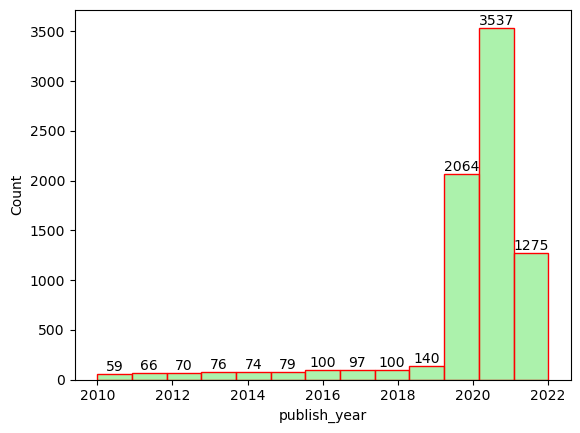

In [13]:
import seaborn as sns

ax = sns.histplot(df["publish_year"], color='lightgreen', edgecolor='red', bins=13) 
ax.bar_label(ax.containers[0])

# Histogram of Journal

In [23]:
a = df.groupby('journal').filter(lambda x: len(x) > 150)
a.head

<bound method NDFrame.head of                                       paper_id publish_time  \
7     558a983bdb9af64c95042df9b0766d021a415df2   2021-05-25   
10    8d9b3e8675a84f1878acb70c48469a299efa7362   2021-11-15   
16    92312f877a8530d8ebf5564a08b4520e5a8d0a37   2021-06-18   
34    fb0368a2b50a4861533301413935d7d63d21564a   2021-10-14   
45    5fd70b490a118989ae475ec05fe5f344cd38c522   2021-09-24   
...                                        ...          ...   
8969  bab276604cdc9e06ee6df8fa921f7aa07cef75ac   2020-11-04   
8984  1c9fba5073560f4fdd8c06dca39d70cd4c49153f   2021-11-23   
8986  18910856b917289b6bb3cc2cef0f78ff82ad4b02   2010-06-25   
8987  7351244545d1bf6931dafe757794d9a39bc4a452   2021-08-31   
8993  b2fc64d0ed4c25e0a58e1971e510d9b68afef9a5   2022-01-12   

                               doi  \
7           10.3390/ijerph18115630   
10    10.1371/journal.pone.0259149   
16    10.1371/journal.pone.0253451   
34         10.3390/ijerph182010807   
45         10.3390/ijer

[Text(0, 0, '263'), Text(0, 0, '260'), Text(0, 0, '194')]

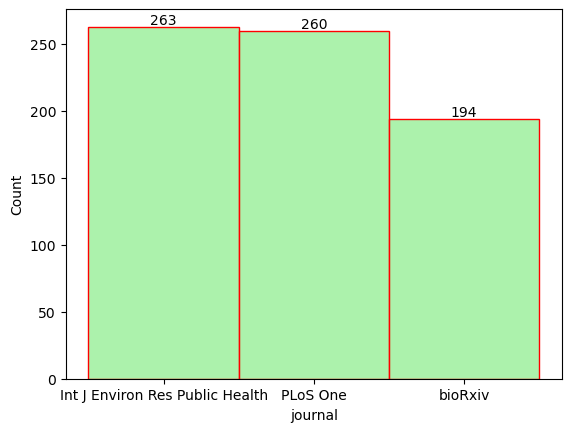

In [24]:
bx = sns.histplot(a['journal'], color='lightgreen', edgecolor='red') 
bx.bar_label(bx.containers[0])


# Remove Stop Word

In [ ]:
#NLP
import spacy
import string
from spacy.lang.en import STOP_WORDS

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[0:10]

custom_stop_words = [
    'doi','preprint','copyright','peer','reviewed','org','https','et','al','author','figure',
    'rights','reserved','permission','used','using','biorxiv','medrxiv','license','fig','fig.',
    'al.','Elsevier','PMC','CZI',
    'a', 'after', 'also', 'an', 'and', 'as', 'at', 'base', 'between', 'but', 'by', 'did', 'do', 'does', 'during', 'for', 'from', 
    'have', 'has', 'had', 'however',
    'in', 'is', 'it', 'its', 'new', 'of', 'on', 'or', 
    'that', 'the', 'to', 'use', 'using', 'was', 'we', 'were', 'which', 'with', '='
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

# Parser
#parser = en_core_sci_lg.load(disable=["tagger","ner"])
#nlp = spacy.load('en_core_web_sm',disable=["tagger","ner"])
nlp = spacy.load('en_core_web_sm',disable=["tagger","parser","ner"]) # Only tokenization and lemmation are performed, POS tagging, NER and syntactic parsing are skipped.
nlp.max_length = 7000000

stopwords = set(stopwords)
punctuations = set(punctuations)
print('len(stopwords):',len(stopwords),'len(punctuations):',len(punctuations))

def spacy_tokenizer(sentence):
    mytokens = nlp(sentence)
    mytokens = [word.lemma_.lower().strip() if word.lemma != '-PORN-' else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stopwords and word not in punctuations]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

tqdm.pandas()
df['procesed_text'] = df['body_text'].progress_apply(spacy_tokenizer)
df['procesed_abstract'] = df['abstract'].progress_apply(spacy_tokenizer)
df.head()

# Map-Reduce 

In [ ]:
import csv
import re
from collections import defaultdict
from functools import reduce

# Sample data: list of documents (each document is a string)
documents_MR = []
with open(metadata_path, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        documents_MR.append(row[4])  # Assuming the 4th column is at index 3 (0-based indexing)
        documents_MR.append(row[9])  # Assuming the 9th column is at index 4 (0-based indexing)


# Specify the words to include in the stoplist
stop_words_upper = ["A", "After", "Also", "An", "And", "As", "At", "Base", "Between", "But", "By", "Did", "Do", "Does", "During", "For", "From", "Have", "Has", "Had", "However",
                    "In", "Is", "It", "Its", "New", "Of", "On", "Or", "That", "The", "To", "Use", "Using", "Was", "We", "Were", "Which", "With", "="]
stop_words_lower = [word.lower() for word in stop_words_upper]

# Mapper function
def map_function(documents_MR):
    # Split the document into words and assign an ID to each word
    for idx, word in enumerate(documents_MR.split(), start=1):
      yield (word.lower(), 1)

# Step 1: Map phase
mapped = []
for documents_MR in documents_MR:
    mapped.extend(map_function(documents_MR))

# Step 2: Shuffle and sort phase (group by key)
shuffled = defaultdict(list)
for word, count in mapped:
    shuffled[word].append(count)

# Step 3: Reduce phase
reduced = {}
for word, counts in shuffled.items():
    reduced[word] = reduce(lambda x, y: x + y, counts)

# Step 4: Merge the counts of words with uppercase and lowercase versions together
merged_counts = defaultdict(int)
for word, count in reduced.items():
    merged_word = re.sub(r'[^a-zA-Z0-9]', '', word)
    # Remove non-alphanumeric characters
    merged_counts[merged_word.lower()] += count

# Step 5.1: filter out the stop words
filtered = {word: count for word, count in reduced.items() if word not in stop_words_upper and word not in stop_words_lower}

# Step 5.2: Sort the filtered words by count in descending order
sorted_words = sorted(filtered.items(), key=lambda x: x[1], reverse=True)
sorted_words_unfilter = sorted(reduced.items(), key=lambda x: x[1], reverse=True)

# Step 5.3: Get the top 50 prevalent words
top50_filtered = sorted_words[:50]
top50_unfilter = sorted_words_unfilter[:80]


# Step 6.1: Print the table of the top 50 prevalent words without stop words list
print("Top 80 Prevalent Words without stopwords:")
print(f"{'ID':<4}{'Word':<20}{'Count'}")
print("-----------------------------")
for idx, (word, count) in enumerate(top50_unfilter, start=1):
    print(f"{idx:<4}{word:<20}{count}")
print("\n"+"\n")


In [ ]:

# Step 6.2: Print the table of the top 50 prevalent words with IDs
print("Top 50 Prevalent Words:")
print(f"{'ID':<4}{'Word':<20}{'Count'}")
print("-----------------------------")
for idx, (word, count) in enumerate(top50_filtered, start=1):
    print(f"{idx:<4}{word:<20}{count}")

# Association Analysis

In [ ]:
df['procesed_abstract_list'] = df['procesed_abstract'].str.split()
df['procesed_abstract_list'].head()

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules 
from mlxtend.preprocessing import TransactionEncoder

# Pre-processing
te = TransactionEncoder()
te_ary = te.fit (df['procesed_abstract_list']).transform(df['procesed_abstract_list'])
df_processd_text = pd.DataFrame (te_ary, columns=te.columns_)
print(df_processd_text)

In [ ]:
# Building the model 
frq_items = apriori(df_processd_text, min_support = 0.04, use_colnames = True) 
frq_items

In [ ]:
  
# Collecting the inferred rules in a dataframe 
rules = association_rules(frq_items, metric ="confidence", min_threshold = 0.5) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print(rules) 

# Similarity Analysis

# Clustering Analysis

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(text,max_feature):
    
    vectorizer = TfidfVectorizer(max_features=max_feature)
    X = vectorizer.fit_transform(text)
    
    return X

text = df['processed_text'].values
max_feature = 2**12

X = vectorize(text,max_feature)

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

# PCA
pca = PCA(n_components=0.95,random_state=42)
X_reduced = pca.fit_transform(X.toarray())
X_reduced.shape

# K Mean Clustering
k = 10
kmeans = KMeans(n_clusters=k,random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns

tsne = TSNE(verbose=1,perplexity=50) # Change perplexity from 100 to 50 per FAQ
X_embedded = tsne.fit_transform(X.toarray())

# sns setting
sns.set(rc={'figure.figsize':(15,15)})

# color
palette = sns.color_palette('bright',1)

# plot
sns.scatterplot(x=X_embedded[:,0],y=X_embedded[:,1],palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig('t-sne_covid19.png')
plt.show()

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# color
palette = sns.color_palette(20,l=4,s=0.9)

# plot
sns.scatterplot(x=X_embedded[:,0],y=X_embedded[:,1],hue=y_pred, legend='full',palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig('improved_cluster_tsne.png')
plt.show()